# TF-IDF (Term Frequency-Inverse Document Frequency)

## Set up

In [1]:
import pandas as pd
from pathlib import Path
import os

import numpy as np
from scipy.sparse import load_npz
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PATH = Path.cwd().parents[2]
DATA_PATH = os.path.join(PATH, 'data/processed/ir_gigahorse')

## Load Your Data

In [3]:
X = load_npz(os.path.join(DATA_PATH, "tfidf_vector_opcode.npz"))
grouping_X = load_npz(os.path.join(DATA_PATH, "tfidf_vector_grouping_opcode.npz"))
y = np.load(os.path.join(DATA_PATH, "labels.npy"))

# Optional: stratify on dominant class (if multilabel → use IterativeStratification later)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
grouping_X_train, grouping_X_val, grouping_y_train, grouping_y_val = train_test_split(grouping_X, y, test_size=0.2, random_state=42)

## List Traditional ML model to compare

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

models = {
  # MultiOutputClassifier Wrappers
  "MultiOutputClassifier(LogisticRegression())": MultiOutputClassifier(LogisticRegression()),
  "MultiOutputClassifier(DecisionTreeClassifier())": MultiOutputClassifier(DecisionTreeClassifier()),
  "MultiOutputClassifier(RandomForestClassifier())": MultiOutputClassifier(RandomForestClassifier()),
  "MultiOutputClassifier(AdaBoostClassifier())": MultiOutputClassifier(AdaBoostClassifier()),
  "MultiOutputClassifier(ExtraTreesClassifier())": MultiOutputClassifier(ExtraTreesClassifier()),
  "MultiOutputClassifier(XGBClassifier())": MultiOutputClassifier(XGBClassifier()),
  "MultiOutputClassifier(LGBMClassifier())": MultiOutputClassifier(LGBMClassifier()),
  "MultiOutputClassifier(SVC())": MultiOutputClassifier(SVC()),
  "MultiOutputClassifier(GaussianNB())": MultiOutputClassifier(GaussianNB()),
  "MultiOutputClassifier(KNeighborsClassifier())": MultiOutputClassifier(KNeighborsClassifier()),
  "MultiOutputClassifier(SGDClassifier())": MultiOutputClassifier(SGDClassifier()),
  "MultiOutputClassifier(MLPClassifier())": MultiOutputClassifier(MLPClassifier()),

  # OneVsRestClassifier Wrappers
  "OneVsRestClassifier(LogisticRegression())": OneVsRestClassifier(LogisticRegression()),
  "OneVsRestClassifier(DecisionTreeClassifier())": OneVsRestClassifier(DecisionTreeClassifier()),
  "OneVsRestClassifier(RandomForestClassifier())": OneVsRestClassifier(RandomForestClassifier()),
  "OneVsRestClassifier(AdaBoostClassifier())": OneVsRestClassifier(AdaBoostClassifier()),
  "OneVsRestClassifier(ExtraTreesClassifier())": OneVsRestClassifier(ExtraTreesClassifier()),
  "OneVsRestClassifier(XGBClassifier())": OneVsRestClassifier(XGBClassifier()),
  "OneVsRestClassifier(LGBMClassifier())": OneVsRestClassifier(LGBMClassifier()),
  "OneVsRestClassifier(SVC())": OneVsRestClassifier(SVC()),
  "OneVsRestClassifier(GaussianNB())": OneVsRestClassifier(GaussianNB()),
  "OneVsRestClassifier(KNeighborsClassifier())": OneVsRestClassifier(KNeighborsClassifier()),
  "OneVsRestClassifier(SGDClassifier())": OneVsRestClassifier(SGDClassifier()),
  "OneVsRestClassifier(MLPClassifier())": OneVsRestClassifier(MLPClassifier()),
}

## Run all models and collect reports

In [5]:
def get_report_all_ml(X_train, y_train, X_test, y_test):
    report_list = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Generate classification report (as dict)
        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        # Average scores across all labels (macro average)
        avg_scores = report_dict["macro avg"]

        report_list.append({
            "Model": name,
            "Precision": avg_scores["precision"],
            "Recall": avg_scores["recall"],
            "F1-score": avg_scores["f1-score"]
        })

    df_report = pd.DataFrame(report_list)
    df_report = df_report.sort_values("F1-score", ascending=False).reset_index(drop=True)

    return df_report

## Show report

In [6]:
def display_multilabel_confusion_matrix(y_test, y_pred):
    # Ensure y_test and y_pred are binary numeric arrays
    y_test_array = np.array(y_test, dtype=int)
    y_pred_array = np.array(y_pred, dtype=int)

    # Generate multi-label confusion matrix again using numeric arrays
    conf_matrices_fixed = multilabel_confusion_matrix(y_test_array, y_pred_array)

    # Plot each confusion matrix again to confirm it's fixed
    _, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, (cm, label) in enumerate(zip(conf_matrices_fixed, ['mint', 'leak', 'limit'])):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

In [7]:
X_train = X_train.toarray()
X_val = X_val.toarray()
df_report = get_report_all_ml(X_train, y_train, X_val, y_val)
df_report

/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15, number of negative: 38
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283019 -> initscore=-0.929536
[LightGBM] [Info] Start training from score -0.929536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this war

[LightGBM] [Info] Number of positive: 15, number of negative: 38
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283019 -> initscore=-0.929536
[LightGBM] [Info] Start training from score -0.929536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Precision,Recall,F1-score
0,OneVsRestClassifier(SGDClassifier()),0.319048,0.583333,0.397661
1,MultiOutputClassifier(ExtraTreesClassifier()),0.555556,0.350000,0.375758
2,OneVsRestClassifier(ExtraTreesClassifier()),0.555556,0.350000,0.375758
3,MultiOutputClassifier(RandomForestClassifier()),0.523810,0.350000,0.355556
4,OneVsRestClassifier(RandomForestClassifier()),0.523810,0.350000,0.355556
5,MultiOutputClassifier(DecisionTreeClassifier()),0.301587,0.350000,0.317460
6,MultiOutputClassifier(GaussianNB()),0.333333,0.233333,0.273810
7,OneVsRestClassifier(GaussianNB()),0.333333,0.233333,0.273810
8,MultiOutputClassifier(KNeighborsClassifier()),0.291667,0.283333,0.264957
9,OneVsRestClassifier(KNeighborsClassifier()),0.291667,0.283333,0.264957


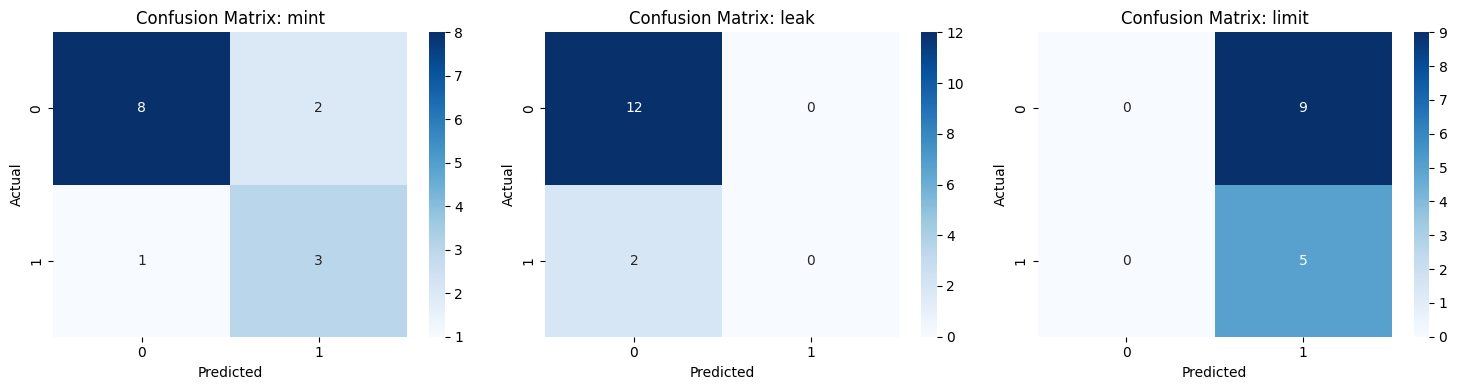

In [8]:
best_model = models[df_report['Model'][0]]
y_pred = best_model.predict(X_val)

display_multilabel_confusion_matrix(y_val, y_pred)

In [9]:
grouping_X_train = grouping_X_train.toarray()
grouping_X_val = grouping_X_val.toarray()
df_report = get_report_all_ml(grouping_X_train, grouping_y_train, grouping_X_val, grouping_y_val)
df_report

/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15, number of negative: 38
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283019 -> initscore=-0.929536
[LightGBM] [Info] Start training from score -0.929536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circ

[LightGBM] [Info] Number of positive: 15, number of negative: 38
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283019 -> initscore=-0.929536
[LightGBM] [Info] Start training from score -0.929536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Precision,Recall,F1-score
0,OneVsRestClassifier(GaussianNB()),0.477778,0.616667,0.537374
1,MultiOutputClassifier(GaussianNB()),0.477778,0.616667,0.537374
2,MultiOutputClassifier(DecisionTreeClassifier()),0.385185,0.583333,0.460317
3,MultiOutputClassifier(AdaBoostClassifier()),0.533333,0.366667,0.422222
4,OneVsRestClassifier(AdaBoostClassifier()),0.533333,0.366667,0.422222
5,OneVsRestClassifier(ExtraTreesClassifier()),0.600000,0.350000,0.400000
6,MultiOutputClassifier(ExtraTreesClassifier()),0.555556,0.350000,0.375758
7,OneVsRestClassifier(RandomForestClassifier()),0.523810,0.350000,0.355556
8,MultiOutputClassifier(LGBMClassifier()),0.347222,0.366667,0.344322
9,OneVsRestClassifier(LGBMClassifier()),0.347222,0.366667,0.344322
